In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Changer le backend à 'inline' pour afficher les figures directement dans le notebook
plt.switch_backend('module://ipykernel.pylab.backend_inline')
from matplotlib.animation import FuncAnimation
from csv_file import export_data_csv, read_csv_file
from squirmer import Squirmer
from plot import plot_sim_nsquirmers, plot_sim_squirmer_border, create_video_from_history, plot_time
from IPython.display import display, clear_output
import time

In [9]:
class InteractingSquirmers:

    def __init__(self, N, xs, ys, orientations, radius, beta, v0, Nx, Ny, dt, dt_out, T, Es, ds, mu, Eo, lnEps_cr, Do, no, border=True):
        self.N = N
        self.xs = np.array(xs, dtype=float)
        self.ys = np.array(ys, dtype=float)
        self.orientations = np.array(orientations, dtype=float)
        self.radius = radius
        self.beta = beta
        self.v0 = v0
        self.Nx = Nx
        self.Ny = Ny
        self.dt = dt
        self.dt_out = dt_out
        self.Es = Es
        self.mu = mu
        self.Eo = Eo
        self.ds = ds
        self.T = T
        self.lnEps_cr = lnEps_cr
        self.Do = Do
        self.no = no
        self.nos = np.zeros(N, dtype=float)
        self.Fs_x, self.Fs_y, self.Fl_x, self.Fl_y, self.val, self.gamma_w = np.zeros(N, dtype=float), np.zeros(N, dtype=float), np.zeros(N, dtype=float), np.zeros(N, dtype=float), np.zeros(N, dtype=float), np.zeros(N, dtype=float)
        self.Fs_pw = np.zeros((2,N), dtype=float)
        #border = true || false, true for reflective, false for periodic 
        self.border = border

        colors = list(matplotlib.colors.CSS4_COLORS.keys())
        colors = [color for color in colors if not self.is_light_color(matplotlib.colors.CSS4_COLORS[color])]
        np.random.shuffle(colors)
        self.colors = colors[:N]
        
        self.squirmers = np.empty(N, dtype=object)

        for i in range(N):
            self.squirmers[i] = Squirmer(self.xs[i], self.ys[i], self.orientations[i], radius, beta, v0)
        self.B1 = self.squirmers[0].B1
        self.B2 = self.squirmers[0].B2

    def is_light_color(self, hex_color):
        #Define what a color too bright is
        rgb = matplotlib.colors.hex2color(hex_color)
        luminance = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
        return luminance > 0.7

    def polar_order_parameter(self):
        #Returns the polar order parameter
        sum1 = 1./self.N*np.sum(np.cos(self.orientations))
        sum2 =  1./self.N*np.sum(np.sin(self.orientations))
        summ_final = np.sqrt(sum1**2 + sum2**2)
        return summ_final
    
    def is_in_square(self):
        #return True if the squirmers are in the square
        return np.all(abs(self.xs) <= (self.Nx - self.radius)) & np.all(abs(self.ys) <= (self.Ny - self.radius))

    def check_squirmers_square(self):
        #return True if the squirmers have been successfully initialized
        if (self.is_in_square() == False):
            raise ValueError("Squirmers must be inside the square")
        return True
    
    def distance_sq(self, squirmer1, squirmer2):
        #return distance between the two squirmers
        Dx = squirmer2.x - squirmer1.x
        Dy = squirmer2.y - squirmer1.y
        return Dx, Dy, np.sqrt(Dx**2 + Dy**2)
    
    def distance_all(self):
        Dxs = self.xs - self.xs[:, None]
        Dys = self.ys - self.ys[:, None]
        dists = np.sqrt(Dxs**2 + Dys**2)
        return Dxs, Dys, dists
    
    def distance_center(self, squirmer):
        #Compute the distance between the squirmers and the center (0,0)
        dist = np.sqrt(squirmer.x**2 + squirmer.y**2)
        return dist

    def forcesSteric(self, Dxs, Dys, dists):
        #Compute the steric forces between two particles
        a = self.radius

        tmp = -3*(self.Es/a)*(2*(2*a/dists)**13-(2*a/dists)**7)/np.sqrt(dists)
        Fs_x =  tmp*Dxs
        Fs_y = tmp*Dys
        return Fs_x, Fs_y
    
    def torquesLubrification(self, Dx, Dy, dist, theta):
        #Computes the lubrification torques produced by two interacting squirmers
        B1 = self.B1
        B2 = self.B2
        a = self.radius

        eieijt = (np.cos(theta)*Dy - np.sin(theta)*Dx)/dist
        cosalpha = (np.cos(theta)*Dx + np.sin(theta)*Dy)/dist

        sinalpha = np.sqrt(np.maximum((1 - cosalpha * cosalpha), 0))
        somme = - B1 * sinalpha - B2 * cosalpha*sinalpha

        lnEps = -np.log(np.maximum(self.lnEps_cr,(dist/a - 2)))
                
        val = (16/10)*self.mu*np.pi*(a**2)*eieijt*somme*lnEps
        val2 = (1/4)*val
        
        return val, val2
        
    def forcesLubrification(self, Dx, Dy, dist, theta):
        #Computes the lubrification forces between two particles
        B1 = self.B1
        B2 = self.B2
        a = self.radius

        eieijt = (np.cos(theta)*Dy - np.sin(theta)*Dx)/dist
        cosalpha = (np.cos(theta)*Dx + np.sin(theta)*Dy)/dist

        sinalpha = np.sqrt(np.maximum((1 - cosalpha * cosalpha), 0))
        somme = - B1 * sinalpha - B2 * cosalpha*sinalpha
        sommeFz = B1 * sinalpha * cosalpha - (1/2)*B1 * cosalpha * eieijt**2 + B2 * sinalpha * cosalpha**2 - (1/2)*B2 * (2*cosalpha**2-1) * eieijt**2

        lnEps = -np.log(np.maximum(self.lnEps_cr,(dist/a - 2)))
        
        #lambda=1
        F_x = np.pi * self.mu * a * eieijt * somme * lnEps * Dx
        F_y = -9* self.mu * np.pi*a*(1/4)*sommeFz* lnEps * Dy

        return F_x, F_y
    
    def compute_force_squirmer_border_x(self, xs, ys):
        RRi = np.sqrt((xs - self.Nx)**2 + (ys - self.Ny)**2)
        tmp = -6*((self.Es*(self.Nx - xs))/(self.radius*RRi))*(2*(self.radius/RRi)**13-(self.radius/RRi)**7)
        return tmp*xs
    
    def compute_force_squirmer_border_y(self, xs, ys):
        RRi = np.sqrt((xs - self.Nx)**2 + (ys - self.Ny)**2)
        tmp = -6*((self.Es*(self.Ny - ys))/(self.radius*RRi))*(2*(self.radius/RRi)**13-(self.radius/RRi)**7)
        return tmp*ys

    def compute_torque_squirmer_border(self, xs, ys, orientations):
        Dy = self.Ny-abs(ys)
        Dx = self.Nx-abs(xs)
        dist = np.sqrt(Dx**2 + Dy**2)
        theta = orientations
        B1 = self.B1
        B2 = self.B2
        a = self.radius

        eieijt = (np.cos(theta)*Dy - np.sin(theta)*Dx)/dist
        cosalpha = (np.cos(theta)*Dx + np.sin(theta)*Dy)/dist

        sinalpha = np.sqrt(np.maximum((1 - cosalpha * cosalpha), 0))
        somme = - B1 * sinalpha - B2 * cosalpha*sinalpha
        lnEps = -np.log(np.maximum(self.lnEps_cr,(dist/a - 2)))

        gamma_w = (16/5)*self.mu*np.pi*(a**2)*eieijt*somme*lnEps
        # dist_center = np.sqrt(squirmer.x**2 + squirmer.y**2)
        # ex = squirmer.x / dist_center
        # ey = squirmer.y / dist_center

        # lnEps = -np.log(max(self.lnEps_cr, (self.R - dist_center)/squirmer.radius - 1))

        # gamma_w = 2*self.Eo*(1 + squirmer.beta*(np.cos(squirmer.orientation)*ex + np.sin(squirmer.orientation)*ey)) * \
        #         lnEps*(np.sin(squirmer.orientation)*ex - np.cos(squirmer.orientation)*ey)
        
        return gamma_w
    
    #Reflective boundary condition
    def ref_border_x(self, xs, orientation, boundary):
        diff = abs(self.Nx - abs(xs))
        orientation = np.pi - orientation
        #Keeps orientation between [0, 2pi]
        # squirmer.orientation = squirmer.orientation % (2 * np.pi)
        if boundary == 1:
            #1 for the right border
            xs = self.Nx - diff
        else:
            xs = -self.Nx + diff

        return xs, orientation
    
    def ref_border_y(self, ys, orientation, boundary):
        orientation = -orientation
        #Keeps orientation between [0, 2pi]
        # squirmer.orientation = squirmer.orientation % (2 * np.pi)
        diff = abs(self.Ny - abs(ys))
        if boundary == 1:
            #1 for the up boundary
            ys = self.Ny - diff
        else:
            ys = -self.Ny + diff

        return ys, orientation

    def perio_border_x(self, xs, boundary):
        if boundary == 1:
            #1 for right boundary
            xs -= 2*self.Nx
        else:
            xs += 2*self.Nx
        return xs

    def loop_time(self):
        self.vector_dists_min = []
        tout = self.dt_out
        a = self.radius
        history = []
        data = [self.xs.tolist(), self.ys.tolist(), self.orientations.tolist(),
                self.Fs_x.tolist(), self.Fs_y.tolist(), self.Fl_x.tolist(), self.Fl_y.tolist(),
                self.val.tolist(), self.gamma_w.tolist(), self.Fs_pw.tolist(), 0]
        history.append(data)
        self.list_polar = []

        fig, ax = plt.subplots()
        ax.set_xlim(-self.Nx, self.Nx)
        ax.set_ylim(-self.Ny, self.Ny)
        nb_pixl_fig = fig.get_size_inches()[0]*fig.dpi
        radius_scatter = nb_pixl_fig/(2*self.Ny/a)
        m = radius_scatter/2

        for t in np.arange(0, self.T, self.dt):
            self.Fs_x.fill(0)
            self.Fs_y.fill(0)
            self.Fl_x.fill(0)
            self.Fl_y.fill(0)
            self.val.fill(0)
            self.gamma_w.fill(0)
            self.Fs_pw.fill(0)
            self.nos.fill(0)

            Dxs, Dys, dists = self.distance_all()

            dist = np.array(dists)
            dist_nz = dist[dist!=0]
            if dist_nz.size > 0:
                min_dist = np.min(dist_nz - 2*a)
                self.vector_dists_min.append(min_dist)

            # for i, s in enumerate(self.squirmers):
            #     dist_steric = (dists[i,:]<self.ds)&(dists[i,:]!=0)
            #     dist_lubrification = (dists[i,:]<=3*a)&(dists[i,:]!=0)

            #     #Steric forces
            #     if np.any(dist_steric):
            #         j_dist_steric = np.where(dist_steric)[0]
            #         Fs_x, Fs_y = self.forcesSteric(Dxs[i, j_dist_steric], Dys[i, j_dist_steric], dists[i, j_dist_steric])
            #         self.Fs_x[i] -= np.sum(Fs_x)
            #         self.Fs_y[i] -= np.sum(Fs_y)

            #     #Lubrification forces and torques
            #     if np.any(dist_lubrification):
            #         j_dist_lubr = np.where(dist_lubrification)[0]
    
            #         # Calcul vectorisé des forces et torques pour toutes les paires
            #         Dx_lubr = Dxs[i, j_dist_lubr]
            #         Dy_lubr = Dys[i, j_dist_lubr]
            #         dist_lubr = dists[i, j_dist_lubr]
            #         orientations_lubr = self.orientations[j_dist_lubr]
                    
            #         Fl_x, Fl_y = self.forcesLubrification(Dx_lubr, Dy_lubr, dist_lubr, orientations_lubr)
            #         val1, val2 = self.torquesLubrification(Dx_lubr, Dy_lubr, dist_lubr, orientations_lubr)
                    
            #         # Mise à jour des forces et des torques
            #         self.Fl_x[i] += np.sum(Fl_x)
            #         self.Fl_y[i] += np.sum(Fl_y)
            #         self.Fl_x[j_dist_lubr] -= Fl_x
            #         self.Fl_y[j_dist_lubr] -= Fl_y
            #         self.val[i] += np.sum(val1)
            #         self.val[j_dist_lubr] += val2
            dist_steric = (dists < self.ds) & (dists != 0)
            dist_lubrification = (dists <= 3 * a) & (dists != 0)

            # Trouver les indices des squirmers impliqués dans chaque interaction
            j_dist_steric = np.where(dist_steric)
            j_dist_lubr = np.where(dist_lubrification)

            # Calcul des forces stériques
            Fs_x, Fs_y = self.forcesSteric(Dxs[j_dist_steric], Dys[j_dist_steric], dists[j_dist_steric])
            # print(Fs_x)
            self.Fs_x[j_dist_steric[0]] -= np.sum(Fs_x)
            self.Fs_y[j_dist_steric[0]] -= np.sum(Fs_y)
            self.Fs_x[j_dist_steric[1]] += Fs_x
            self.Fs_y[j_dist_steric[1]] += Fs_y

            # Calcul des forces de lubrification et des torques
            Fl_x, Fl_y = self.forcesLubrification(Dxs[j_dist_lubr], Dys[j_dist_lubr], dists[j_dist_lubr], self.orientations[j_dist_lubr[0]])
            val1, val2 = self.torquesLubrification(Dxs[j_dist_lubr], Dys[j_dist_lubr], dists[j_dist_lubr], self.orientations[j_dist_lubr[0]])

            # Mise à jour des valeurs des forces et des torques
            self.Fl_x[j_dist_lubr[0]] += np.sum(Fl_x)
            self.Fl_y[j_dist_lubr[0]] += np.sum(Fl_y)
            self.Fl_x[j_dist_lubr[1]] -= Fl_x
            self.Fl_y[j_dist_lubr[1]] -= Fl_y
            self.val[j_dist_lubr[0]] += np.sum(val1)
            self.val[j_dist_lubr[1]] += val2

            #Noise
            self.nos = np.random.uniform(-self.no/2, self.no/2, size=self.N)

            #Force between a squirmer and a border
            dist_forces_x = (self.Nx-abs(self.xs)) < 2**(1/6)*a
            dist_forces_y = (self.Ny-abs(self.ys)) < 2**(1/6)*a

            dist_torques_x = (self.Nx - abs(self.xs)) < 2*a
            dist_torques_y = (self.Ny - abs(self.ys)) < 2*a

            #If we simulate in a box
            if self.border:
                i_dist_force_x = np.where(dist_forces_x)[0]
                i_dist_torque_x = np.where(dist_torques_x)[0]
                self.Fs_pw[0][i_dist_force_x] += self.compute_force_squirmer_border_x(self.xs[i_dist_force_x], self.ys[i_dist_force_x])
                self.gamma_w[i_dist_torque_x] += self.compute_torque_squirmer_border(self.xs[i_dist_torque_x], self.ys[i_dist_torque_x], self.orientations[i_dist_torque_x])

            i_dist_force_y = np.where(dist_forces_y)[0]
            i_dist_torque_y = np.where(dist_torques_y)[0]
            self.Fs_pw[1][i_dist_force_y] += self.compute_force_squirmer_border_y(self.xs[i_dist_force_y], self.ys[i_dist_force_y])
            self.gamma_w[i_dist_torque_y] += self.compute_torque_squirmer_border(self.xs[i_dist_torque_y], self.ys[i_dist_torque_y], self.orientations[i_dist_torque_y])

            self.orientations += self.dt*(self.val + self.gamma_w) + np.sqrt(2*self.dt*self.Do)*self.nos
            self.xs += self.dt*(self.v0*np.cos(self.orientations) - self.Fs_x - self.Fs_pw[0] + self.Fl_x)
            self.ys += self.dt*(self.v0*np.sin(self.orientations) - self.Fs_y - self.Fs_pw[1] + self.Fl_y)
            
            self.list_polar.append(self.polar_order_parameter())

            #Borders
            mask_x1 = (self.Nx - self.xs) <= a
            mask_x2 = (self.Nx + self.xs) <= a
            mask_y1 = (self.Ny - self.ys) <= a
            mask_y2 = (self.Ny + self.ys) <= a
            #x_borders
            if np.any(mask_x1):
                #Box simulation
                if self.border:
                    self.xs[mask_x1], self.orientations[mask_x1] = self.ref_border_x(self.xs[mask_x1], self.orientations[mask_x1], 1)
                #Chanel simulation
                else:
                    self.xs[mask_x1] = self.perio_border_x(self.xs[mask_x1], 1)
            if np.any(mask_x2):
                #Box simulation
                if self.border:
                    self.xs[mask_x2], self.orientations[mask_x2] = self.ref_border_x(self.xs[mask_x2], self.orientations[mask_x2], 2)
                #Chanel simulation
                else:
                    self.xs[mask_x2] = self.perio_border_x(self.xs[mask_x2], 2)
            
            #y_borders
            if np.any(mask_y1):
                self.ys[mask_y1], self.orientations[mask_y1] = self.ref_border_y(self.ys[mask_y1], self.orientations[mask_y1], 1)
            if np.any(mask_y2):
                self.ys[mask_y2], self.orientations[mask_y2] = self.ref_border_y(self.ys[mask_y2], self.orientations[mask_y2], 2)

            for i, s in enumerate(self.squirmers):
                s.x = self.xs[i]
                s.y = self.ys[i]
                s.orientation = self.orientations[i]
            
            if t >= tout:
                print(tout)
                data = [self.xs.tolist(), self.ys.tolist(), self.orientations.tolist(),
                        self.Fs_x.tolist(), self.Fs_y.tolist(), self.Fl_x.tolist(), self.Fl_y.tolist(),
                        self.val.tolist(), self.gamma_w.tolist(), self.Fs_pw.tolist(), tout]
                history.append(data)
                tout += self.dt_out
                # print(f"polar parameter : {polar}")

                ax.clear()
                ax.set_xlim(-self.Nx, self.Nx)
                ax.set_ylim(-self.Ny, self.Ny)
                for i in range(self.N):
                    ax.plot(self.xs[i], self.ys[i], 'o', markersize=m)
                    ax.plot([self.xs[i], self.xs[i] + 0.1 * np.cos(self.orientations[i])], 
                            [self.ys[i], self.ys[i] + 0.1 * np.sin(self.orientations[i])], '-')
                
                plt.draw()
                plt.pause(0.001)
                plt.show()
                
        self.history = history
        return history


[-1.84447482 -0.82885119 -1.08937242 -1.69994255 -0.29927467 -0.30405422
 -0.40856608 -0.42378153  0.9256388  -1.4324331   0.84134186 -0.50682707
  1.53020473 -0.31273153 -0.91839953 -0.25717317  1.07047094  1.44548711
  0.66055871 -0.08059547 -1.21910779  1.41942665 -0.65160684 -1.01690587
 -1.57802679  0.77364278  0.7137      0.71742371 -1.29996621  0.78131252
  0.69086743  1.25584359  1.26171659  1.52281286  0.93914191  1.48868733
 -1.14890368  1.34898025  0.09540709  1.10867769  1.2507295  -1.09184919
  1.16565023  1.53940464 -0.06682893 -0.1369043  -1.85944146  1.76949305
  1.41678558 -0.1221369  -0.40065176  0.46262253  1.14727423 -1.77114569
 -1.45738278 -1.27865897 -0.92577789  0.88594251  0.34153852  0.37466701
 -0.28638136  0.26888712  1.13440271 -0.85676144  1.57914028  1.09938656
 -1.1694714   0.8510967   0.52128535  1.52152113  0.0541106   1.8160731
  1.85922231 -0.68873597  1.58523347  1.70665672 -0.70348308  0.03728517
  0.21750945  1.03894476 -0.76994983 -1.08124278  1.

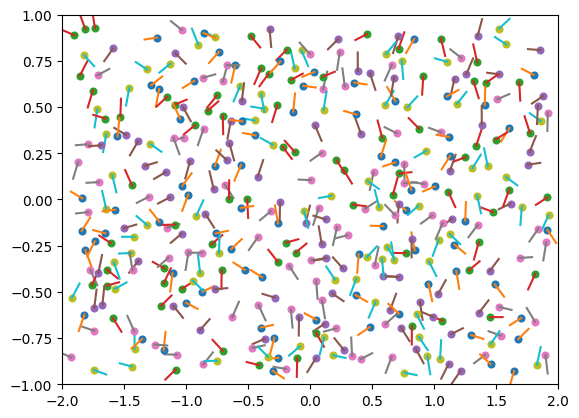

0.02


<Figure size 640x480 with 0 Axes>

0.03


<Figure size 640x480 with 0 Axes>

0.04


<Figure size 640x480 with 0 Axes>

0.05


<Figure size 640x480 with 0 Axes>

0.060000000000000005


<Figure size 640x480 with 0 Axes>

0.07


<Figure size 640x480 with 0 Axes>

0.08


<Figure size 640x480 with 0 Axes>

0.09


<Figure size 640x480 with 0 Axes>

0.09999999999999999


<Figure size 640x480 with 0 Axes>

0.10999999999999999


<Figure size 640x480 with 0 Axes>

0.11999999999999998


<Figure size 640x480 with 0 Axes>

0.12999999999999998


KeyboardInterrupt: 

In [10]:
v0 = 0.3
#length x and y axis
lbda = 2
Ly = 2
Lx = lbda*Ly
#half of the length of axis
Nx = Lx/2
Ny = Ly/2
#squirmers' radius
a = 0.03
#betas
beta = 7.5
#time-step
dt = 1e-4
#cut-off for -log
lnEps_cr = np.exp(-5)
#amplitude of steric interactions
Es = 1
#simulation time
T = 1
#periodicity of outputs
dt_out = 0.01
#viscovity parameter
mu = 1
#amplitude of orientational interactions
#Eo[0] = Eoinitial, E[1] = Eobrumley, E[2] = Eolauga
Eo = [(((3./10.)*v0/a), "Eo_init"), ((16/10)*mu*np.pi*a**2, "Eo_brumley"), ((-3./2.)*(v0/a), "Eo_lauga"),
        (((-3./10.)*v0/a), "mEo_init"), (-5, "m5"), (0.005, "m0_005"), (-2, "m2"), (-0.5, "m0_5"),
        (0.5, "0_5")]

#distance of steric interactions
ds = 2**(7./6)*a
#angular diffusivity
Do = 1e-2
#angular noise
no = 1e-4
N = 375
#coordinates and orientations
orients = np.zeros(N, dtype=float)
orients = np.random.uniform(0, 2*np.pi, size=N)
xs = np.empty(N)
ys = np.empty(N)

for k in range(N):
    while True:
        x = np.random.uniform(-(Nx-2*a), (Nx-2*a))
        y = np.random.uniform(-(Ny-2*a), (Ny-2*a))
        if k == 0 or np.all(np.sqrt((xs[:k] - x)**2 + (ys[:k] - y)**2) > 2*a):
            xs[k] = x
            ys[k] = y
            break
print(xs)
print("initialisation passée")
#border to simulate chanel or box
border = False
#border_plot to do the simulation of the border or not
border_plot = True
filename = 'test_opti4'
dir = 'videos'

interact_sq = InteractingSquirmers(N, xs, ys, orients, a, beta, v0, Nx, Ny, dt, dt_out, T, Es, ds, mu, Eo[0][0], lnEps_cr, Do, no, border)
history = interact_sq.loop_time()
plot_time(interact_sq, interact_sq.vector_dists_min, "min_dist_" + filename, 'minimal distance', dir)
plot_time(interact_sq, interact_sq.list_polar, "polar_" + filename, 'polar parameter', dir)